# LLM Evaluation
This notebook evaluates the groundedness guardrail using Commonwealth Bank of Australia Retail Products.

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import random
import time
from datetime import datetime,date
import pandas as pd
import csv
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import pretty_print_docs,calculate_cosine_similarity
from src.utils import calculate_bleu_rouge
from src.retriever_builder import build_ensemble_retriever_from_markdown
from pydantic import BaseModel
from src.rag_evaluator import evaluate_rag


### Prompt + Model Comparison
Cosine Similarity (Semantic Match):
    Measures how semantically close the generated answer is to the expected one.
    Best for identifying hallucinations or off-topic responses.
    High cosine = strong conceptual grounding.



In [ ]:
def load_prompt(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

# Set paths
prompt_dir = Path("prompt")
markdown_path = os.getcwd() + '\\docsModel\\CBA_All_Retail_Products.md'
evaluation_question_path = os.getcwd() + '\\CBA_Chatbot_Evaluation_30_Questions.csv'

# Configs to test
models = ["gemma3:4b", "phi3:latest"]
prompt_files = list(prompt_dir.glob("*.txt"))

# Run all evaluations
results_list = []

for model in models:
    for prompt_file in prompt_files:
        prompt_name = prompt_file.stem
        print(f"🧪 Evaluating: model={model}, prompt={prompt_name}")

        template = load_prompt(prompt_file)

        result_df = evaluate_rag(
            evaluation_question_path=evaluation_question_path,
            template=template,
            markdown_path=markdown_path,
            search_kwargs=5,
            model=model
        )

        result_df["prompt_used"] = prompt_name
        result_df["model_used"] = model
        results_list.append(result_df)

# Combine results and save
all_results_df = pd.concat(results_list, ignore_index=True)
csv_path=os.getcwd() +'\\Outputs\\rag_eval_comparison.csv'
all_results_df.to_csv(csv_path, index=False)



🧪 Evaluating: model=gemma3:4b, prompt=default_prompt
load INSTRUCTOR_Transformer
max_seq_length  512


100%|██████████| 30/30 [06:24<00:00, 12.83s/it]


   Preparing the results...
Evaluation finished...
🧪 Evaluating: model=gemma3:4b, prompt=sales_focused_prompt
load INSTRUCTOR_Transformer
max_seq_length  512


100%|██████████| 30/30 [08:23<00:00, 16.79s/it]


   Preparing the results...
Evaluation finished...
🧪 Evaluating: model=gemma3:4b, prompt=strict_grounding_prompt
load INSTRUCTOR_Transformer
max_seq_length  512


100%|██████████| 30/30 [06:52<00:00, 13.76s/it]


   Preparing the results...
Evaluation finished...
🧪 Evaluating: model=gemma3:4b, prompt=structured_prompt
load INSTRUCTOR_Transformer
max_seq_length  512


100%|██████████| 30/30 [07:54<00:00, 15.82s/it]


   Preparing the results...
Evaluation finished...
🧪 Evaluating: model=phi3:latest, prompt=default_prompt
load INSTRUCTOR_Transformer
max_seq_length  512


100%|██████████| 30/30 [09:06<00:00, 18.23s/it]


   Preparing the results...
Evaluation finished...
🧪 Evaluating: model=phi3:latest, prompt=sales_focused_prompt
load INSTRUCTOR_Transformer
max_seq_length  512


100%|██████████| 30/30 [09:45<00:00, 19.51s/it]


   Preparing the results...
Evaluation finished...
🧪 Evaluating: model=phi3:latest, prompt=strict_grounding_prompt
load INSTRUCTOR_Transformer
max_seq_length  512


100%|██████████| 30/30 [08:04<00:00, 16.15s/it]


   Preparing the results...
Evaluation finished...
🧪 Evaluating: model=phi3:latest, prompt=structured_prompt
load INSTRUCTOR_Transformer
max_seq_length  512


100%|██████████| 30/30 [58:37<00:00, 117.24s/it]  


   Preparing the results...
Evaluation finished...


In [57]:
summary = all_results_df.groupby(["model_used", "prompt_used"])["cosine_similarity"].mean().reset_index()
summary.columns = ["Model", "Prompt", "Avg Cosine Similarity"]
print(summary)

         Model                   Prompt  Avg Cosine Similarity
0    gemma3:4b           default_prompt               0.676512
1    gemma3:4b     sales_focused_prompt               0.523941
2    gemma3:4b  strict_grounding_prompt               0.701216
3    gemma3:4b        structured_prompt               0.654136
4  phi3:latest           default_prompt               0.533184
5  phi3:latest     sales_focused_prompt               0.498927
6  phi3:latest  strict_grounding_prompt               0.594235
7  phi3:latest        structured_prompt               0.525930


### Evaluation Function (BLEU + ROUGE)
BLEU-1 (Precision):
    Measures how many words in the generated answer overlap with the reference.
    Focused on surface-level accuracy (doesn't handle paraphrasing).
    High BLEU = more fluent and exact matches.

ROUGE-1 / ROUGE-L (Recall + Structure):
    ROUGE-1: Measures coverage of key words.
    ROUGE-L: Measures structural similarity using longest common subsequence.
    High ROUGE = more complete and well-aligned answers.


In [4]:
# Load your results CSV
csv_path=os.getcwd() +'\\Outputs\\rag_eval_comparison.csv'
df = pd.read_csv(csv_path)

metrics_df = df.apply(calculate_bleu_rouge, axis=1)
df_results = pd.concat([df, metrics_df], axis=1)
csv_path_1=os.getcwd() +'\\Outputs\\evaluation_all_metric.csv'
df_results.to_csv(csv_path_1,index=False)

### Visualize Summary of Prompt + Model Evaluation

In [5]:
metrics = ["cosine_similarity", "bleu", "rouge1", "rougeL"]
summary = df_results.groupby(["model_used", "prompt_used"])[metrics].mean().reset_index()

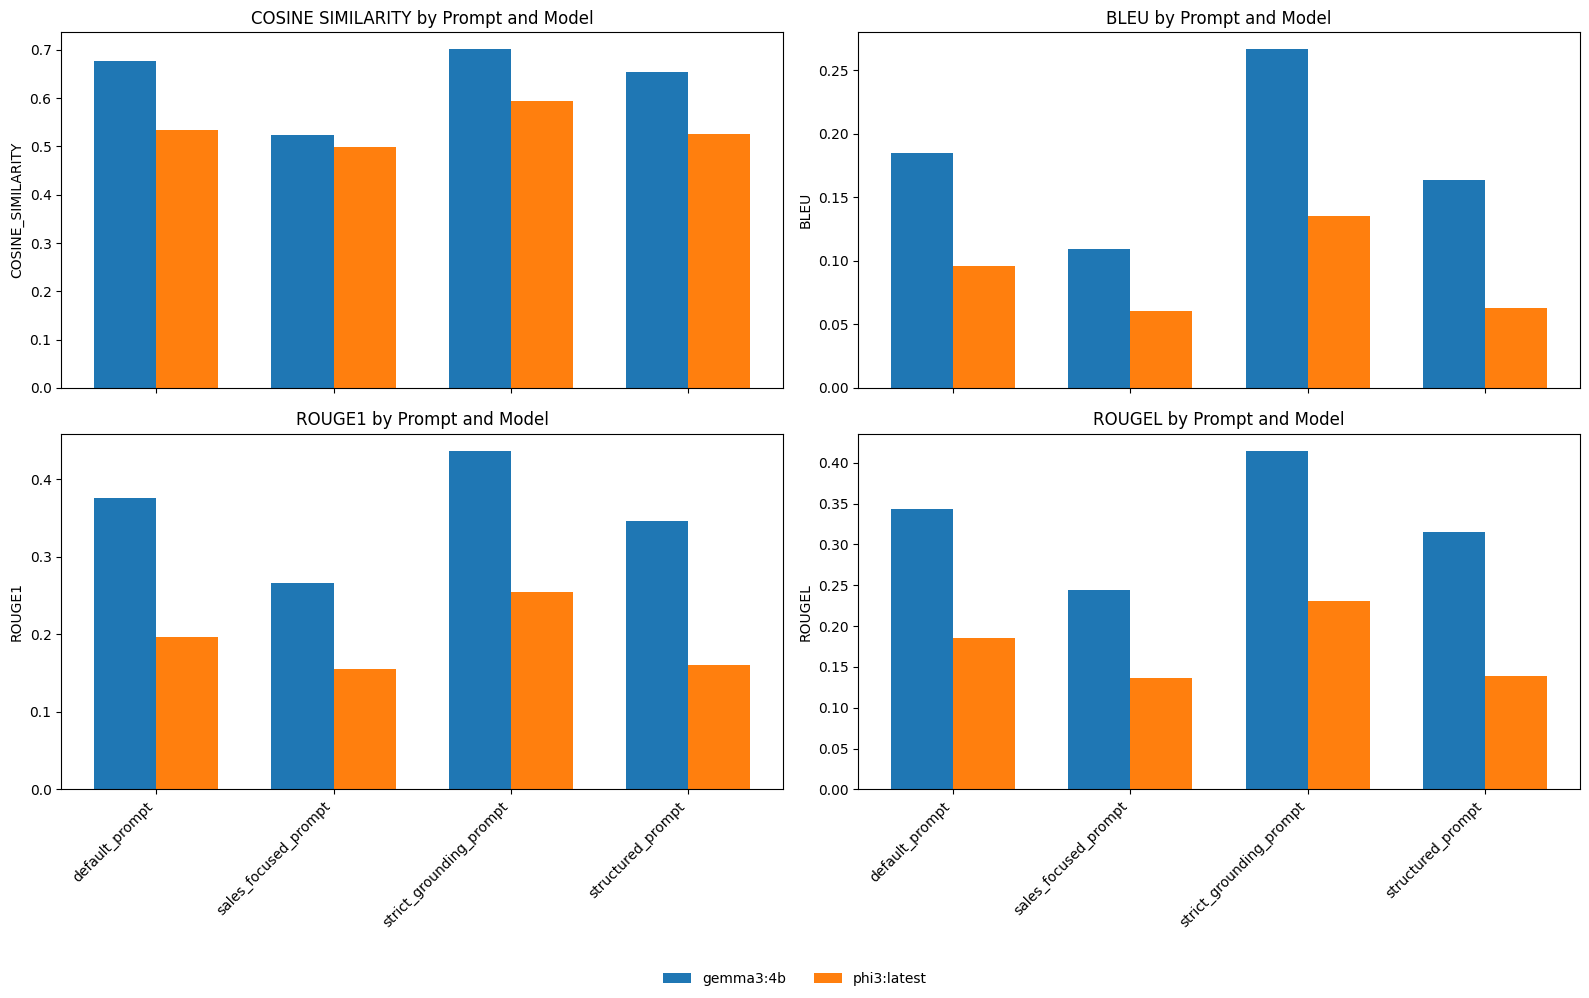

In [6]:
prompts = summary["prompt_used"].unique()
models = summary["model_used"].unique()
bar_width = 0.35
x = np.arange(len(prompts))
# Create one plot per metric

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

for idx, metric in enumerate(metrics):
    row, col = divmod(idx, 2)
    ax = axs[row][col]

    for i, model in enumerate(models):
        model_scores = summary[summary["model_used"] == model][metric]
        ax.bar(x + i * bar_width, model_scores, width=bar_width, label=model)

    ax.set_title(f"{metric.replace('_', ' ').upper()} by Prompt and Model")
    ax.set_ylabel(metric.upper())
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(prompts, rotation=45, ha="right")
    ax.grid(False)  # ❌ No gridlines

# Shared legend
fig.legend(models, loc="lower center", ncol=len(models), frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])
png_path=os.getcwd() +'\\Outputs\\evaluation_metrics_bar.png'
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()

In [7]:
summary.pivot(index="prompt_used", columns="model_used", values=metrics)

cosine_similarity                  bleu              \
model_used                      gemma3:4b phi3:latest gemma3:4b phi3:latest   
prompt_used                                                                   
default_prompt                   0.676512    0.533184  0.184628    0.096030   
sales_focused_prompt             0.523941    0.498927  0.109531    0.060387   
strict_grounding_prompt          0.701216    0.594235  0.266471    0.135506   
structured_prompt                0.654136    0.525930  0.163911    0.063067   

                           rouge1                rougeL              
model_used              gemma3:4b phi3:latest gemma3:4b phi3:latest  
prompt_used                                                          
default_prompt           0.375441    0.196186  0.342737    0.185890  
sales_focused_prompt     0.265788    0.154951  0.243536    0.136944  
strict_grounding_prompt  0.436839    0.254754  0.414665    0.231206  
structured_prompt        0.346385    0.160096  0.315398    0.138526